# Feature-Aware Data Augmentation

Augmentation policies to consider:
- Simple policy randomly sampling of n transforms 
- Constrained sampling policy with a blacklist of transforms to avoid 
- Feature-aware augmentation policy where transforms are picked based on their (transform, feature) behavior

In [1]:
# data
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from datasets import load_dataset, load_from_disk
from datasets.utils.logging import disable_progress_bar

# amrs
import amrlib
import penman

# transform
import sibyl
import torch
import inspect
import random
from functools import partial

# eval pipeline
import pandas as pd
from transformers import pipeline
from huggingface_hub import HfApi, ModelFilter
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from scipy.special import softmax

# train pipeline
import shutil
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    Trainer, 
    TrainingArguments, 
    EarlyStoppingCallback
)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
torch.use_deterministic_algorithms(False)
disable_progress_bar()

In [122]:
# helper functions

def normalize_minmax(df):
    for column in df.columns:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())  
    return df

def normalize_sum(df):
    for column in df.columns:
        df[column] = df[column] / df[column].sum()
    return df

def augment_data(batch, transform, keep_originals=True):
    new_texts, new_labels = [], []
    for text, label in zip(batch['text'], batch['label']):
        new_text, new_label = transform.apply([text], [label])
        new_texts.extend(new_text)
        new_labels.extend(new_label)
    if keep_originals:
        return {"text": batch['text'] + new_texts, "label": batch['label'] + new_labels}
    else:
        return {"text": new_texts, "label": new_labels}
    
def percent_dataset_changed(d1, d2):
    return sum([t1['text'] != t2['text'] for t1, t2 in zip(d1, d2)]) / len(d1) 

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    acc = accuracy_score(labels, predictions.argmax(-1))
    precision, recall, fbeta_score, support = precision_recall_fscore_support(
        y_true=labels, 
        y_pred=predictions.argmax(-1), 
        average="weighted", 
        zero_division=0)
    return { 'accuracy': acc , 
             'precision': precision, 
             'recall': recall, 
             'fbeta_score': fbeta_score} 

def compute_accuracy(predictions, labels):
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels)
    if len(labels.shape) > 1:
        acc = acc_at_k(labels, predictions, k=2)       
    else:
        acc = accuracy_score(labels, np.argmax(predictions, -1))
    return acc

def vectorize(output):
    sorted_output = sorted(output, key=lambda d: d['label']) 
    probs = torch.tensor([d['score'] for d in sorted_output])
    return probs

def sample_transforms(transforms, p, n=2, replace=False):
    return np.random.choice(transforms, size=n, p=p, replace=replace).tolist()

def policy_heatmap(policy, transforms, featurizers):
    t_names = [t.transform_class.__name__ for t in transforms]
    f_names = [f.__name__ for f in featurizers]
    df = pd.DataFrame(policy)
    df.columns = f_names
    df.index = t_names
    sns.heatmap(df)
    plt.show()
    
def implement_policy_probabilities(policy, features):
    default_probability = policy.mean(axis=1)
    policy_probs = []
    for f in features:
        available_features = np.nonzero(f)[0]
        if len(available_features) == 0:
            probs = default_probability
        else:
            probs = policy[:, available_features].mean(axis=1)
        policy_probs.append(probs)
    return np.array(policy_probs)

In [4]:
class Transform:
    def __init__(self, transform_class, num_outputs=1, task_name="sentiment"):
        self.transform_class = transform_class
        self.num_outputs = num_outputs
        self.task_name = task_name
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.intakes_target = False
        self.is_batched = False
        
        # setting class attributes
        if 'to_tense' in inspect.signature(self.transform_class).parameters:
            print("initializing class with to_tense='past'") # future & random don't work
            self.transform_instance = self.transform_class(to_tense="past")
        elif 'source_lang' in inspect.signature(self.transform_class).parameters:
            print("initializing class with source_lang='es'") 
            self.transform_instance = self.transform_class(source_lang="es")
        elif 'task_name' in inspect.signature(self.transform_class).parameters:
            print(f"initializing class with task_name='{task_name}', return_metadata=True") 
            self.transform_instance = self.transform_class(task_name=self.task_name, return_metadata=True)
        # elif isinstance(self.transform_class, LostInTranslation):
        #     self.transform_instance = self.transform_class(device=0)
        else:
            self.transform_instance = self.transform_class()
        
        # setting instance attributes
        if hasattr(self.transform_instance, "max_outputs"):
            print(f"setting max_outputs={self.num_outputs}")
            self.transform_instance.max_outputs = self.num_outputs
        if hasattr(self.transform_instance, "max_paraphrases"):
            print(f"setting max_paraphrases={self.num_outputs}")
            self.transform_instance.max_paraphrases = self.num_outputs
        if hasattr(self.transform_instance, "device"):
            if self.transform_instance.device is None or self.transform_instance.device == 'cpu':
                print(f"setting device={self.device}")
                self.transform_instance.device = self.device
        
        # selecting the transformation function
        if hasattr(self.transform_class, "generate"):
            self.transform_fn = self.transform_instance.generate
        if hasattr(self.transform_class, "augment"):
            self.transform_fn = self.transform_instance.augment
        if hasattr(self.transform_class, "transform_batch"):
            self.transform_fn = self.transform_instance.transform_batch
            self.intakes_target = True
            self.is_batched = True
            
    def synced_shuffle(self, list1, list2):
        # Shuffle two lists with same order
        # Using zip() + * operator + shuffle()
        temp = list(zip(list1, list2))
        random.shuffle(temp)
        res1, res2 = zip(*temp)
        # res1 and res2 come out as tuples, and so must be converted to lists.
        res1, res2 = list(res1), list(res2)
        return res1, res2
            
    def apply(self, texts, labels=None):
        if self.intakes_target:
            if self.is_batched:
                new_texts, new_labels = self.transform_fn((texts, labels))
            else:
                new_texts, new_labels = [], []
                for t, l in zip(texts, labels):
                    new_t, new_l = self.transform_fn(t, l)
                    new_texts.append(new_t)
                    new_labels.extend([new_l] * len(new_t))
        else:
            if self.is_batched:
                new_texts = self.transform_fn((texts))
                new_texts = labels
            else:
                new_texts, new_labels = [], []
                for t, l in zip(texts, labels):
                    new_t = self.transform_fn(t)
                    if len(new_t) > self.num_outputs:
                        new_t = new_t[:self.num_outputs]
                    new_texts.extend(new_t)
                    new_labels.extend([l] * len(new_t))
                    
        # post processing since some transformations add/remove more new outputs than expected
        if len(new_texts) == 0:
            print("no new_texts, substituting original texts...")
            new_texts = texts
        if len(new_labels) == 0:
            print("no new_labels, substituting original labels...")
            new_labels = labels
        new_texts, new_labels = self.synced_shuffle(new_texts, new_labels)
        
        expected_len = len(texts) * self.num_outputs
        new_texts = new_texts[:expected_len]
        new_labels = new_labels[:expected_len]
        
        return new_texts, new_labels

In [5]:
class AMRGraph:
    def __init__(self, amr):
        self.graph = penman.decode(amr) if not isinstance(amr, penman.graph.Graph) else amr
        self.amr_text = penman.encode(self.graph)

    def contains_concept(self, concepts):
        """
        Concepts are nodes / instances in the AMR graph.
        """
        try:
            if not isinstance(concepts, list): concepts = [concepts]
            graph_concepts = [t.target for t in self.graph.instances()]
            return any(c for c in graph_concepts if c in concepts)
        except Exception as e:
            print(e)
            print(self.graph, self.amr_text)

    def contains_role(self, roles):
        """
        Roles are edges in the AMR graph.
        """
        try:
            if not isinstance(roles, list): roles = [roles]
            graph_roles = [e.role for e in self.graph.edges()]
            return any(r for r in graph_roles if r in roles)
        except Exception as e:
            print(e)
            print(self.graph, self.amr_text)

    def contains_attribute(self, attributes):
        """
        Attributes are properties of concept nodes, i.e. relationships to 
        constant values.
        """
        try:
            if not isinstance(attributes, list): attributes = [attributes]
            graph_attrs = [a.target for a in self.graph.attributes()]
            return any(a for a in graph_attrs if a in attributes)
        except Exception as e:
            print(e)
            print(self.graph, self.amr_text)

In [6]:
# attributes =============================================================

def contains_imperative(g): return g.contains_attribute("imperative")
def contains_exlamation(g): return g.contains_attribute("expressive")
def contains_negation(g):   return g.contains_attribute("-")

# concepts ===============================================================

def contains_conjunctions(g):         return g.contains_concept(["and", "or", "contrast-01", "either", "neither"])
def contains_interrogative_clause(g): return g.contains_concept("truth-value")
def contains_question(g):             return g.contains_concept(["amr-unknown", "amr-choice"])

# roles ==================================================================

def contains_coreferences(g): return any(r for r in g.amr_text.split() if r in ['i', 'you', 'he', 'she', 'it', 'we', 'they'])
def contains_number(g):       return any(a for a in g.graph.attributes() if a.target.isnumeric())

def contains_accompanier(g):  return g.contains_role(':accompanier')
def contains_age(g):          return g.contains_role(':age')
def contains_beneficiary(g):  return g.contains_role(':beneficiary')
def contains_concession(g):   return g.contains_role(':concession')
def contains_condition(g):    return g.contains_role(':condition')
def contains_consist_of(g):   return any(r for r in g.amr_text.split() if r in [':consist-of'])
def contains_degree(g):       return g.contains_role(':degree')
def contains_destination(g):  return g.contains_role(':destination')
def contains_direction(g):    return g.contains_role(':direction')
def contains_domain(g):       return g.contains_role(':domain')
def contains_duration(g):     return g.contains_role(':duration')
def contains_example(g):      return g.contains_role(':example')
def contains_extent(g):       return g.contains_role(':extent')
def contains_frequency(g):    return g.contains_role(':frequency')
def contains_instrument(g):   return g.contains_role(':instrument')
# def contains_li(g):           return g.contains_role(':li')
def contains_location(g):     return g.contains_role(':location')
def contains_manner(g):       return g.contains_role(':manner')
def contains_medium(g):       return g.contains_role(':medium')
def contains_mod(g):          return g.contains_role(':mod')
def contains_mode(g):         return any(a for a in g.graph.attributes() if ":mode" in a.role)
def contains_name(g):         return g.contains_role(':name')
def contains_ord(g):          return g.contains_role(':ord')
def contains_part(g):         return g.contains_role(':part')
def contains_path(g):         return g.contains_role(':path')
def contains_polarity(g):     return g.contains_role(':polarity')
def contains_polite(g):       return any(r for r in g.amr_text.split() if r in [':polite'])
def contains_poss(g):         return g.contains_role(':poss')
def contains_purpose(g):      return g.contains_role(':purpose')
def contains_quant(g):        return g.contains_role(':quant')
def contains_range(g):        return g.contains_role(':range')
def contains_scale(g):        return g.contains_role(':scale')
def contains_source(g):       return g.contains_role(':source')
def contains_subevent(g):     return g.contains_role(':subevent')
def contains_time(g):         return g.contains_role(':time')
def contains_topic(g):        return g.contains_role(':topic')
def contains_unit(g):         return g.contains_role(':unit')
# def contains_value(g):        return g.contains_role(':value')
def contains_wiki(g):         return g.contains_role(':wiki')

In [7]:
class AMRFeatureExtractor:
    
    def __init__(self):
        self.featurizers = featurizers = [    
            contains_accompanier,
            contains_age,
            contains_beneficiary,
            contains_concession,
            contains_condition,
            contains_conjunctions,
            contains_consist_of,
            contains_coreferences,
            contains_degree,
            contains_destination,
            contains_direction,
            contains_domain,
            contains_duration,
            contains_example,
            contains_exlamation,
            contains_extent,
            contains_frequency,
            contains_imperative,
            contains_instrument,
            contains_interrogative_clause,
            contains_location,
            contains_manner,
            contains_medium,
            contains_mod,
            contains_mode,
            contains_name,
            contains_negation,
            contains_number,
            contains_ord,
            contains_part,
            contains_path,
            contains_polarity,
            contains_polite,
            contains_poss,
            contains_purpose,
            contains_quant,
            contains_question,
            contains_range,
            contains_scale,
            contains_source,
            contains_subevent,
            contains_time,
            contains_topic,
            contains_unit
        ]
        self.featurizers = sorted(featurizers, key=lambda f: f.__name__)
        self.amr_model   = None
        
    def load_amr_model(self, max_sent_len=128):
        self.amr_model = amrlib.load_stog_model(max_sent_len=max_sent_len)
        
    def text_to_amr(self, texts):
        if self.amr_model is None:
            self.load_amr_model()
        amr_penmans = self.amr_model.parse_sents(texts, add_metadata=False, disable_progress=True)
        amr_graphs = []
        for p in amr_penmans:
            try:
                amr_graphs.append(AMRGraph(p))
            except Exception as e: 
                print(e)
                print(p)
                amr_graphs.append(AMRGraph(p))
        return amr_graphs
    
    def generate_feature_matrix(self, graphs):
        feature_matrix = []
        for g in graphs:
            feature_vector = []
            for f in self.featurizers:
                feature_vector.append(f(g))
            feature_matrix.append(feature_vector)
        feature_matrix = np.array(feature_matrix, dtype=np.int32)
        return feature_matrix
    
    def __call__(self, texts):
        graphs = self.text_to_amr(texts)
        return self.generate_feature_matrix(graphs)
        

In [8]:
def transforms_to_ids(sampled_transforms, all_transforms):
    transforms_ids = [all_transforms.index(i) for i in sampled_transforms]
    transforms_applied = np.zeros(len(all_transforms), dtype=np.int32)
    transforms_applied[transforms_ids] = 1
    return transforms_applied

In [151]:
class Augmenter:
    def __init__(self, 
                 dataset,
                 transforms,
                 transform_probabilities = None, 
                 num_augmentations_per_record = 5,
                 num_transforms_to_apply = 2,
                 batch_size = 10,
                 allow_resampling = False,
                 keep_originals = False,
                 feature_extractor = None,
                 perf_extractor = None):
        
        self.dataset = dataset
        self.transforms = transforms
        self.transform_probabilities = transform_probabilities
        self.num_augmentations_per_record = num_augmentations_per_record
        self.num_transforms_to_apply = num_transforms_to_apply
        self.batch_size = batch_size
        self.allow_resampling = allow_resampling
        self.keep_originals = keep_originals
        self.feature_extractor = feature_extractor
        self.perf_extractor = perf_extractor
        
        # initializations
        self.dataset = dataset.remove_columns("idx")
        self.add_idx_to_dataset()
        self.num_transforms_available = len(self.transforms)
        
        if self.transform_probabilities is None:
            # set to uniform
            num_examples = len(self.dataset)
            num_transforms = len(self.transforms)
            uniform_policy = np.full((num_examples, num_transforms), fill_value=1/num_transforms)
            self.transform_probabilities = uniform_policy
        
    def add_idx_to_dataset(self):
        if 'idx' not in self.dataset.features:
            self.dataset = self.dataset.add_column("idx", range(len(self.dataset)))
        
    def apply_to_batch(self, batch):
        new_texts, new_labels, transforms_applied, is_changed = [], [], [], []
        for idx, text, label in zip(batch['idx'], batch['text'], batch['label']):
            actual_batch_size = len(batch['idx'])
            original_text, original_label = text, label
            for _ in range(self.num_augmentations_per_record):
                sampled_transforms = sample_transforms(self.transforms, 
                                                       p=self.transform_probabilities[idx], 
                                                       n=self.num_transforms_to_apply, 
                                                       replace=self.allow_resampling)
                transforms_applied.append(transforms_to_ids(sampled_transforms, self.transforms))
                for t in sampled_transforms:
                    try:
                        text, label = t.apply([text], [label])
                        text, label = text[0], label[0]
                    except Exception as e: 
                        print(e)
                        print(f"[Augmenter]: skipping augmentation from {t.transform_class.__name__} on text:'{text}' and label: {label}")

                # avoid adding records with empty text
                if text:
                    new_texts.append(text)
                    new_labels.append(label)
                    is_changed.append(int(original_text != text))

        if self.keep_originals:
            new_texts = batch['text'] + new_texts
            new_labels = batch['label'] + new_labels
            realized_batch_size = len(new_labels)
            transforms_applied = transforms_applied + np.zeros((actual_batch_size, len(self.transforms)), dtype=np.int32).tolist()
            is_changed = is_changed + [0] * actual_batch_size
            out = {
                "text": new_texts, 
                "label": new_labels,
                "idx": list(range(realized_batch_size)),
                "transforms_applied": [t for t in transforms_applied],
                "is_changed": is_changed
            }
        else:
            out = {
                "text": new_texts, 
                "label": new_labels, 
                "idx": list(range(realized_batch_size)),
                "transforms_applied": transforms_applied,
                "is_changed": is_changed
            }

        return out
            
                                                   
    def augment(self):
        dataset = self.dataset.map(self.apply_to_batch, batched=True, batch_size=self.batch_size)
        dataset = dataset.remove_columns("idx")
    
        # feature extraction
        if self.feature_extractor is not None:
            features = self.feature_extractor(dataset["text"])
            dataset = dataset.add_column("features", [f for f in features])
                
        # performance scoring    
        if self.perf_extractor is not None:
            performances = self.perf_extractor(dataset["text"], dataset["label"])
            dataset = dataset.add_column("performance", [p for p in performances])
                
        return dataset

In [142]:
class Likelihood:
    def __init__(self):
        self.scorer = torch.nn.NLLLoss(reduction="none")
    
    def __call__(self, inputs, targets):
        return -self.scorer(inputs, targets).numpy()
    
class InverseLikelihood:
    def __init__(self):
        self.scorer = torch.nn.NLLLoss(reduction="none")
    
    def __call__(self, inputs, targets):
        return 1+self.scorer(inputs, targets).numpy()

class PerformanceExtractor:
    def __init__(self, dataset_name, scorer, model_id=None):
        self.dataset_name = dataset_name
        self.scorer = scorer
        self.model_id = model_id
        self.api = HfApi()
        self.pipe = None
        self.device = 0 if torch.cuda.is_available() else -1

        if self.model_id and not self.pipe:
            self.create_pipe(self.model_id)

        if not self.pipe:
            self.find_model_for_dataset()

    def create_pipe(self, model_id):
        self.pipe = pipeline("text-classification", 
                            model=model_id, 
                            device=self.device, 
                            padding=True, 
                            truncation=True,
                            top_k=None)
        return self.pipe

    def find_model_for_dataset(self):
        model_filter = ModelFilter(
            task="text-classification",
            library="pytorch",
            # model_name=dataset_name,
            trained_dataset=self.dataset_name)
        model_id = next(iter(self.api.list_models(filter=model_filter)))
        if model_id:
            model_id = getattr(model_id, 'modelId')
            print('Using ' + model_id + ' to support evaluation.')
            self.create_pipe(model_id)

    def extract_prediction_probabilities(self, inputs):
        output = self.pipe(inputs)
        return torch.stack([vectorize(o) for o in output])
    
    def extract_prediction_classes(self, inputs):
        return torch.argmax(self.extract_prediction_probabilities(inputs), axis=1)

    def __call__(self, inputs, targets):
        probs   = self.extract_prediction_probabilities(inputs)
        targets = torch.tensor(targets)
        return self.scorer(probs, targets)

In [127]:
def get_coverage(features, transforms_applied):
    """
        - features : (np.array), shape: (len(dataset), num_features)
        - transforms_applied : (np.array), shape: (len(dataset), num_transforms)
        
        Performs matrix multiplication over the boolean features + transforms applied
        to arrive at a coverage matrix with shape (num_transforms, num_features). This 
        is then used to identify combinations of feature and transform that have not
        yet been observed. 
    """
    return (features.T @ transforms_applied).T

## FADA v2.1

In [25]:
dataset_config = ("glue", "sst2")
task_name = "sentiment"

In [26]:
dataset = load_dataset(*dataset_config, split="train")
dataset = dataset.rename_column("sentence", "text")

Found cached dataset glue (C:/Users/Fabrice/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [27]:
blacklist = [
    sibyl.Emojify,
    sibyl.AddPositiveEmoji,
    sibyl.AddNegativeEmoji,
    sibyl.Demojify,
    sibyl.RemovePositiveEmoji,
    sibyl.RemoveNegativeEmoji,
    sibyl.AddPositiveEmoji,
    sibyl.AddNegativeEmoji,
    sibyl.InsertPositivePhrase,
    sibyl.InsertNegativePhrase,
    sibyl.AddPositiveLink,
    sibyl.AddNegativeLink,
    sibyl.ImportLinkText,
    sibyl.AddNegation,
    sibyl.RemoveNegation,
    sibyl.ChangeAntonym,
    sibyl.ConceptMix,
    sibyl.TextMix,
    sibyl.SentMix,
    sibyl.WordMix,
    sibyl.Concept2Sentence
]
transforms = [t for t in sibyl.TRANSFORMATIONS if t not in blacklist]
transforms = sorted(transforms, key=lambda t: t.__name__)
transforms = [Transform(t, task_name=task_name) for t in transforms]

initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', r

In [28]:
feature_extractor = AMRFeatureExtractor()
perf_extractor = PerformanceExtractor(dataset.builder_name, Likelihood())

Using distilbert-base-uncased-finetuned-sst-2-english to support evaluation.


In [29]:
if os.path.exists("./datasets/glue.sst2.featurized"):
    dataset = load_from_disk("./datasets/glue.sst2.featurized")
    features = np.array(dataset["features"])
else:
    features = feature_extractor(dataset["text"])
    dataset = dataset.add_column("features", [f for f in features])
    dataset.save_to_disk("./datasets/glue.sst2.featurized")

C:\Users\Fabrice\anaconda3\envs\fada\lib\site-packages\datasets\arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


  0%|          | 0/880 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Fabrice\Documents\GitHub\fada\datasets\glue.sst2.featurized\cache-6c2c6223fd07e5eb.arrow
Loading cached processed dataset at C:\Users\Fabrice\Documents\GitHub\fada\datasets\glue.sst2.featurized\cache-23ddc0786e439e48.arrow


policy_difference: 0.49563462287950333 (convergence_threshold: 0.015625)


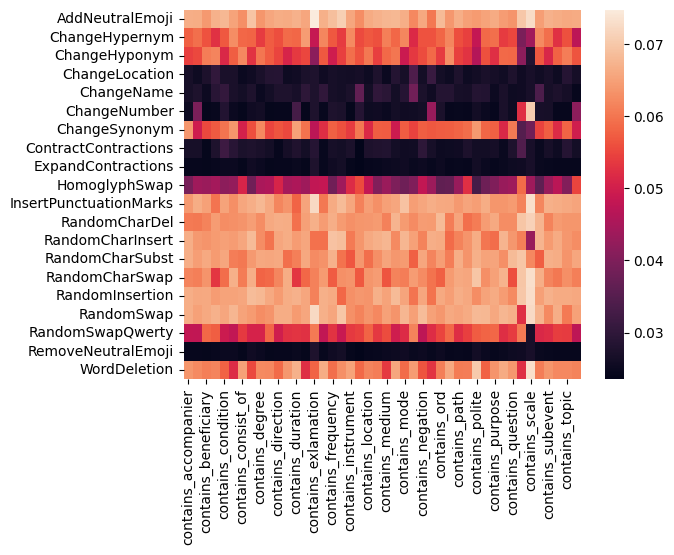

Saving intermediate matrices...


  0%|          | 0/880 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Fabrice\Documents\GitHub\fada\datasets\glue.sst2.featurized\cache-fed26b7540301c9d.arrow
Loading cached processed dataset at C:\Users\Fabrice\Documents\GitHub\fada\datasets\glue.sst2.featurized\cache-3e1ca8822eaa8dc3.arrow


policy_difference: 0.06457532401230963 (convergence_threshold: 0.015625)


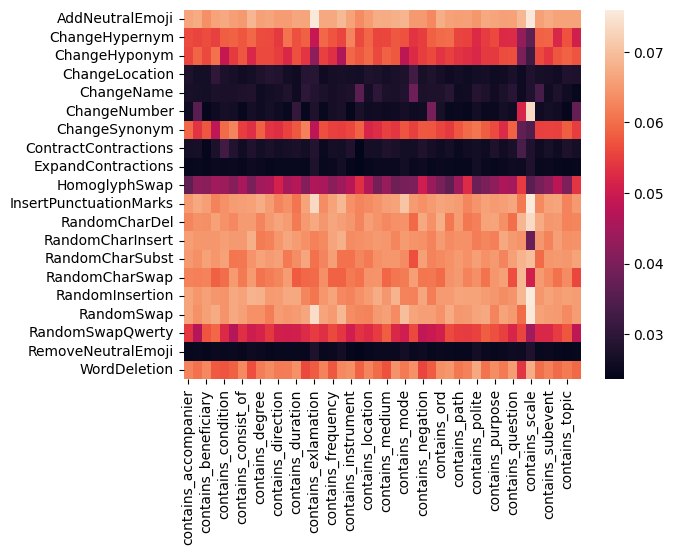

Saving intermediate matrices...


  0%|          | 0/880 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Fabrice\Documents\GitHub\fada\datasets\glue.sst2.featurized\cache-c18d8b1cb5e78c7d.arrow
Loading cached processed dataset at C:\Users\Fabrice\Documents\GitHub\fada\datasets\glue.sst2.featurized\cache-8630fdaad8ada6bc.arrow


policy_difference: 0.0359530828386599 (convergence_threshold: 0.015625)


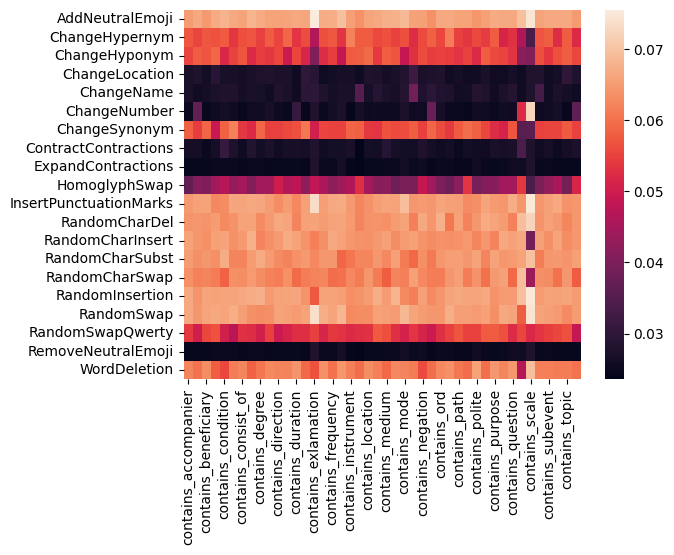

Saving intermediate matrices...


  0%|          | 0/880 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Fabrice\Documents\GitHub\fada\datasets\glue.sst2.featurized\cache-6d9ba0ddd4ccc52a.arrow


policy_difference: 0.02463057466833739 (convergence_threshold: 0.015625)


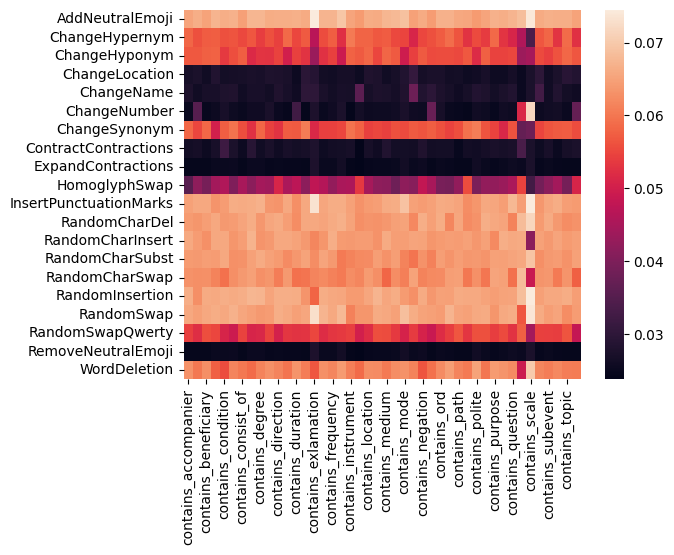

Saving intermediate matrices...


  0%|          | 0/523 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Fabrice\Documents\GitHub\fada\datasets\glue.sst2.featurized\cache-652a19e3f6a21efa.arrow


policy_difference: 0.021816011265308122 (convergence_threshold: 0.015625)


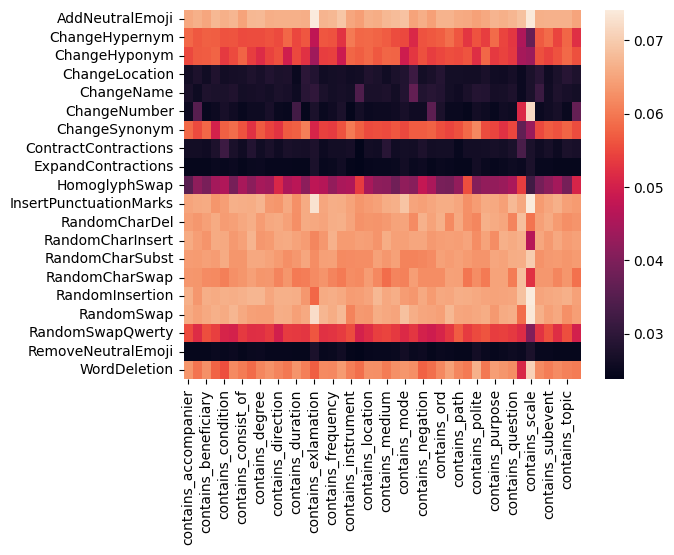

Saving intermediate matrices...


  0%|          | 0/331 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Fabrice\Documents\GitHub\fada\datasets\glue.sst2.featurized\cache-85644de1590c12af.arrow
Loading cached processed dataset at C:\Users\Fabrice\Documents\GitHub\fada\datasets\glue.sst2.featurized\cache-899c609de4c1390f.arrow
Loading cached processed dataset at C:\Users\Fabrice\Documents\GitHub\fada\datasets\glue.sst2.featurized\cache-2c9dd9e1ce3fba8e.arrow


policy_difference: 0.014097458667001156 (convergence_threshold: 0.015625)


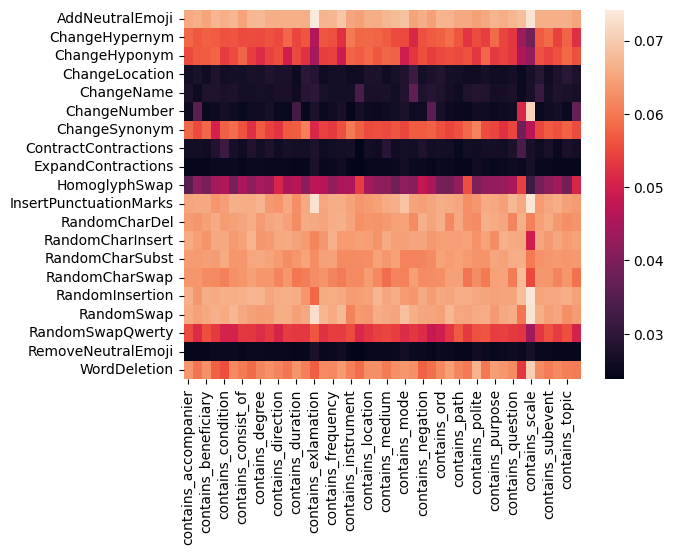

Saving intermediate matrices...


In [96]:
save_dir       = "./fadata/v2/"

num_rows       = len(dataset)
num_transforms = len(transforms)
num_features   = len(feature_extractor.featurizers)

performances   = np.zeros((num_transforms, num_features))
counts         = np.zeros((num_transforms, num_features))
changes        = np.zeros((num_transforms, num_features))
policy         = np.full((num_transforms, num_features), fill_value=1/num_transforms)

min_coverage = 100
num_to_transform_per_step = 25

policy_difference = np.inf
convergence_threshold = 1 / (num_transforms + num_features)

i = 0
while policy_difference > convergence_threshold:

    # find low coverage (t,f) pairs
    ts, fs   = np.where(changes < min_coverage)
    tf_pairs = list(zip(ts, fs))

    for t, f in tqdm(tf_pairs):

        f_candidates  = np.where(features[:,f] == 1)[0]

        # feature missing in dataset
        if not f_candidates.size:
            continue

        num_to_sample = num_to_transform_per_step if len(f_candidates) > num_to_transform_per_step else len(f_candidates)
        f_indices     = np.random.choice(f_candidates, num_to_sample, replace=False)
        f_dataset     = dataset.select(f_indices)

        t_prob = np.zeros(num_transforms)
        t_prob[t] = 1
        transform_probabilities = np.array([t_prob for _ in range(f_dataset.num_rows)])

        augmenter = Augmenter(dataset=f_dataset, 
                      transforms=transforms,  
                      transform_probabilities=transform_probabilities,
                      num_augmentations_per_record=1,
                      num_transforms_to_apply=1,
                      batch_size=1, 
                      keep_originals=False,
                      perf_extractor=perf_extractor)
        aug_dataset = augmenter.augment()

        performance = np.array(aug_dataset["performance"]).sum()
        num_changes = np.array(aug_dataset["is_changed"]).sum()

        counts[t,f]       += f_dataset.num_rows
        changes[t,f]      += num_changes  
        performances[t,f] += performance   

    # compute augmentation policy
    average_performance    = np.nan_to_num(performances / counts, 0)
    applicability_rate     = np.nan_to_num(changes / counts, 0)
    new_policy             = softmax(average_performance * applicability_rate, axis=0)

    policy_difference      = np.linalg.norm(new_policy - policy)
    policy                 = new_policy
    
    print(f"policy_difference: {policy_difference} (convergence_threshold: {convergence_threshold})")
    
    policy_heatmap(policy, transforms, feature_extractor.featurizers)
    
    print("Saving intermediate matrices...")
    np.save(os.path.join(save_dir, f"glue.sst2.fada.v2.counts-step-{i}"), counts)
    np.save(os.path.join(save_dir, f"glue.sst2.fada.v2.changes-step-{i}"), changes)
    np.save(os.path.join(save_dir, f"glue.sst2.fada.v2.performances-step-{i}"), performances)
    np.save(os.path.join(save_dir, f"glue.sst2.fada.v2.policy-step-{i}"), policy)
    
    i += 1

In [ ]:
policy_probabilities = implement_policy_probabilities(policy, features)

In [150]:
augmenter = Augmenter(dataset=dataset, 
                      transforms=transforms, 
                      transform_probabilities=policy_probabilities, 
                      num_augmentations_per_record=1,
                      num_transforms_to_apply=1,
                      keep_originals=True)
aug_dataset = augmenter.augment()
aug_dataset.save_to_disk("./datasets/glue.sst2.sibyl.fada_v2")

## Load Data

In [97]:
dataset_config = ("glue", "sst2")
task_name = "sentiment"

In [98]:
dataset = load_dataset(*dataset_config, split="train")
dataset = dataset.rename_column("sentence", "text")

Found cached dataset glue (C:/Users/Fabrice/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [99]:
blacklist = [
    sibyl.Emojify,
    sibyl.AddPositiveEmoji,
    sibyl.AddNegativeEmoji,
    sibyl.Demojify,
    sibyl.RemovePositiveEmoji,
    sibyl.RemoveNegativeEmoji,
    sibyl.AddPositiveEmoji,
    sibyl.AddNegativeEmoji,
    sibyl.InsertPositivePhrase,
    sibyl.InsertNegativePhrase,
    sibyl.AddPositiveLink,
    sibyl.AddNegativeLink,
    sibyl.ImportLinkText,
    sibyl.AddNegation,
    sibyl.RemoveNegation,
    sibyl.ChangeAntonym,
    sibyl.ConceptMix,
    sibyl.TextMix,
    sibyl.SentMix,
    sibyl.WordMix,
    sibyl.Concept2Sentence
]
transforms = [t for t in sibyl.TRANSFORMATIONS if t not in blacklist]
transforms = sorted(transforms, key=lambda t: t.__name__)
transforms = [Transform(t, task_name=task_name) for t in transforms]

initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', return_metadata=True
initializing class with task_name='sentiment', r

In [100]:
num_examples = len(dataset)
num_transforms = len(transforms)
uniform_policy = np.full((num_examples, num_transforms), fill_value=1/num_transforms)

feature_extractor = AMRFeatureExtractor()
perf_extractor = LossExtractor(dataset.builder_name, Likelihood())

augmenter = Augmenter(dataset=dataset, 
                      transforms=transforms, 
                      transform_probabilities=uniform_policy, 
                      num_augmentations_per_record=1,
                      num_transforms_to_apply=1,
                      batch_size=10, 
                      keep_originals=False,
                      feature_extractor=feature_extractor,
                      perf_extractor=perf_extractor)
aug_dataset = augmenter.augment()

NameError: name 'LossExtractor' is not defined

In [ ]:
num_transforms = len(augmenter.transforms)
num_features = len(feature_extractor.featurizers)

likelihoods = np.zeros((num_transforms, num_features))
counts      = np.zeros((num_transforms, num_features))
changes     = np.zeros((num_transforms, num_features))

for row in aug_dataset:
    for t in np.nonzero(row['transforms_applied'])[0]: 
        for f in np.nonzero(row['features'])[0]: 
            likelihoods[t,f] += row['likelihood']
            counts[t,f]      += 1
            changes[t,f]     += row['is_changed'] # 0 or 1


In [ ]:
losses, counts, change

In [ ]:
counts.sum(axis=1)

In [ ]:
change.sum(axis=1)

In [ ]:
# fada.initialize_transforms()
augmenter = Augmenter(dataset=fada.dataset), 
                      transforms=fada.transforms, 
                      transform_probabilities=fada.policy_probabilities.values, 
                      num_augmentations_per_record = 1,
                      num_transforms_to_apply = 1,
                      keep_originals=keep_originals)
aug_dataset = augmenter.augment()
aug_dataset.save_to_disk("./datasets/glue.sst2.sibyl.fada")

In [ ]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_items(test_list, item):
    return [i for i in test_list if i != item]

def compare_policy_probs(policy_probs, augmented_dataset):
    transforms_applied_flat = flatten(augmented_dataset["transforms_applied"])
    transforms_applied_flat = remove_items(transforms_applied_flat, "Identity")
    unique, counts = np.unique(transforms_applied_flat, return_counts=True)
    percents = counts / counts.sum()
    df = pd.DataFrame([policy_probs.mean(axis=0), pd.Series(percents, index=unique)]).T
    df.columns = ["policy", "actual"]
    df["difference"] = df["policy"] - df["actual"]
    return df

In [ ]:
compare_policy_probs(policy_probs, aug_dataset)

In [ ]:
num_examples = len(fada.dataset)
num_transforms = len(fada.transforms)
uniform_policy = np.full((num_examples, num_transforms), fill_value=1/num_transforms)

augmenter = Augmenter(dataset=fada.dataset.select(range(1000)), 
                      transforms=fada.transforms, 
                      transform_probabilities=fada.policy_probabilities.values[:1000], 
                      num_augmentations_per_record = 1,
                      num_transforms_to_apply = 1,
                      keep_originals=keep_originals)
uni_dataset = augmenter.augment()
uni_dataset.save_to_disk("./datasets/glue.sst2.sibyl.uniform")

In [ ]:
compare_policy_probs(policy_probs, uni_dataset)

In [ ]:
dataset = load_dataset("glue", "sst2", split="train").select(range(1000))
dataset = dataset.rename_column("sentence", "text")
dataset.save_to_disk("./datasets/glue.sst2.orig")

In [ ]:
dataset = load_dataset("glue", "sst2", split="train") # .select(range(100))
dataset = dataset.rename_column("sentence", "text")

fada_dataset = load_from_disk("./datasets/glue.sst2.sibyl.fada.test").shuffle()
uniform_dataset = load_from_disk("./datasets/glue.sst2.sibyl.uniform").shuffle()

datasets_to_evaluate = [
    ("fada", fada_dataset),
    ("uniform", uniform_dataset),
    ("original", dataset)
]

results = []
for technique_name, technique_dataset in datasets_to_evaluate:
    print(f"training on {technique_name} dataset")
    pipe = TrainPipeline(
        model_id="bert-base-cased", 
        dataset_config=("glue", "sst2"),
        train_batch_size = 16,
        eval_batch_size = 16,
        gradient_accumulation_steps = 1,
        num_epoch = 10,
        seed=0)
    
    pipe.train(technique_dataset)
    out = pipe.calculate_performance()
    out["technique_name"] = technique_name
    print(out)
    results.append(out)
    df = pd.DataFrame(results)
    df.to_csv("train_results.csv", index=False)

## Visualizations

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

In [ ]:
g = sns.heatmap(df_policy)
g.set(title="(transform, feature) Policy", 
      xlabel='AMR Feature', 
      ylabel='Transform',
      xticklabels=[t.get_text().replace("contains_", "") for t in g.get_xticklabels()])
plt.show()

In [ ]:
cols = ['transform', 'featurizer', 'pct_changed']
df_heat = df2[cols].pivot_table(values='pct_changed', 
                               index='transform', 
                               columns='featurizer', 
                               aggfunc='mean')
df_heat = df_heat.loc[(df_heat != 0).any(axis=1)]
# df_heat = df_heat.drop('original')
# df_heat = df_heat.drop('HomoglyphSwap')
g = sns.heatmap(df_heat, cmap="coolwarm_r")
g.set(title="Percent of Examples Changed", 
      xlabel='AMR Feature', 
      ylabel='Transform',
      xticklabels=[t.get_text().replace("contains_", "") for t in g.get_xticklabels()])
plt.show()

In [ ]:
cols = ['transform', 'featurizer', 'impact']
df_heat = df2[cols].pivot_table(values='impact', 
                               index='transform', 
                               columns='featurizer', 
                               aggfunc='mean')
df_heat = df_heat.loc[(df_heat != 0).any(axis=1)]
df_heat = df_heat.drop('original')
df_heat = df_heat.drop('HomoglyphSwap')
g = sns.heatmap(df_heat, cmap="coolwarm_r")
g.set(title="Direct Impact: $\Delta$ in Model Accuracy Based on AMR Feature Presence / Absence", 
      xlabel='AMR Feature', 
      ylabel='Transform',
      xticklabels=[t.get_text().replace("contains_", "") for t in g.get_xticklabels()])
plt.show()

In [ ]:
cols = ['transform', 'featurizer', 'diff_impact']
df_heat = df2[cols].pivot_table(values='diff_impact', 
                               index='transform', 
                               columns='featurizer', 
                               aggfunc='mean')
df_heat = df_heat.loc[(df_heat != 0).any(axis=1)]
df_heat = df_heat.drop('original')
df_heat = df_heat.drop('HomoglyphSwap')
g = sns.heatmap(df_heat, cmap="coolwarm_r")
g.set(title="Disparate Impact: $\Delta$ in Model Accuracy Based on AMR Feature Presence / Absence", 
      xlabel='AMR Feature', 
      ylabel='Transform',
      xticklabels=[t.get_text().replace("contains_", "") for t in g.get_xticklabels()])
plt.show()